setup

In [ ]:
# Install a pip comtradeapicall package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --upgrade comtradeapicall

# Install a pip pandas package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas

# Install a pip matplotlib package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall


subscription_key = "b5856aa064474537a609f9c773a9441d"


Všechny importy 

In [71]:
# Generate commodity chunks explicitly as comma-separated strings
def make_cmd_chunks(start, end, size=20):
    all_codes = [f"{i:02d}" for i in range(start, end + 1)]
    return [','.join(all_codes[i:i + size]) for i in range(0, len(all_codes), size)]

commodity_chunks = make_cmd_chunks(1, 99, size=20)

dfs = []

for chunk in commodity_chunks:
    df = comtradeapicall.getFinalData(
        subscription_key,
        typeCode='C',
        freqCode='A',
        clCode='HS',
        period='2022',
        reporterCode='36',
        cmdCode=chunk,
        flowCode='X',
        partnerCode=None,
        partner2Code=None,
        customsCode=None,
        motCode=None,
        maxRecords=100000,
        format_output='JSON',
        aggregateBy=None,
        breakdownMode='classic',
        countOnly=None,
        includeDesc=True
    )
    dfs.append(df)

# Combine all results into one DataFrame
import pandas as pd
full_data = pd.concat(dfs, ignore_index=True)


In [75]:
df = comtradeapicall.getFinalData(
    subscription_key,
    typeCode='C',
    freqCode='A',
    clCode='HS',
    period='2022',
    reporterCode='36',
    cmdCode='01',          # Vehicles
    flowCode='X',
    partnerCode=None,
    partner2Code=None,
    customsCode=None,
    motCode=None,
    maxRecords=1000,
    format_output='JSON',
    aggregateBy=None,
    breakdownMode='classic',
    countOnly=False,
    includeDesc=True
)

print(df)

   typeCode freqCode  refPeriodId  refYear  refMonth period  reporterCode  \
0         C        A     20220101     2022        52   2022            36   
1         C        A     20220101     2022        52   2022            36   
2         C        A     20220101     2022        52   2022            36   
3         C        A     20220101     2022        52   2022            36   
4         C        A     20220101     2022        52   2022            36   
5         C        A     20220101     2022        52   2022            36   
6         C        A     20220101     2022        52   2022            36   
7         C        A     20220101     2022        52   2022            36   
8         C        A     20220101     2022        52   2022            36   
9         C        A     20220101     2022        52   2022            36   
10        C        A     20220101     2022        52   2022            36   
11        C        A     20220101     2022        52   2022            36   

In [57]:
print(df)

    typeCode freqCode  refPeriodId  refYear  refMonth period  reporterCode  \
0          C        A     20220101     2022        52   2022            36   
1          C        A     20220101     2022        52   2022            36   
2          C        A     20220101     2022        52   2022            36   
3          C        A     20220101     2022        52   2022            36   
4          C        A     20220101     2022        52   2022            36   
..       ...      ...          ...      ...       ...    ...           ...   
995        C        A     20220101     2022        52   2022            36   
996        C        A     20220101     2022        52   2022            36   
997        C        A     20220101     2022        52   2022            36   
998        C        A     20220101     2022        52   2022            36   
999        C        A     20220101     2022        52   2022            36   

    reporterISO reporterDesc flowCode  ...      netWgt  isNetWg

In [74]:
full_data.to_csv('full_data.csv', index=False)


shrnutí

In [76]:
# Total import value by partner country
imports_by_partner = df.groupby('partnerDesc')['fobvalue'].sum().sort_values(ascending=False)

print(imports_by_partner)

partnerDesc
World                   1.055109e+09
Indonesia               3.930431e+08
China                   3.269324e+08
Viet Nam                7.381099e+07
China, Hong Kong SAR    4.848988e+07
Israel                  4.392014e+07
New Zealand             3.395329e+07
Kuwait                  2.866017e+07
Malaysia                1.596980e+07
Japan                   1.528540e+07
United Arab Emirates    1.339947e+07
Philippines             1.292069e+07
Brunei Darussalam       9.878817e+06
United Kingdom          7.787263e+06
USA                     5.414229e+06
China, Macao SAR        3.313323e+06
Netherlands             3.299615e+06
Singapore               2.975262e+06
Oman                    2.773570e+06
Thailand                2.594664e+06
Germany                 2.542693e+06
Qatar                   2.470163e+06
Canada                  1.729654e+06
Pakistan                1.364040e+06
Sri Lanka               8.389282e+05
Rep. of Korea           6.798773e+05
Myanmar                 3.

mám rád koláče

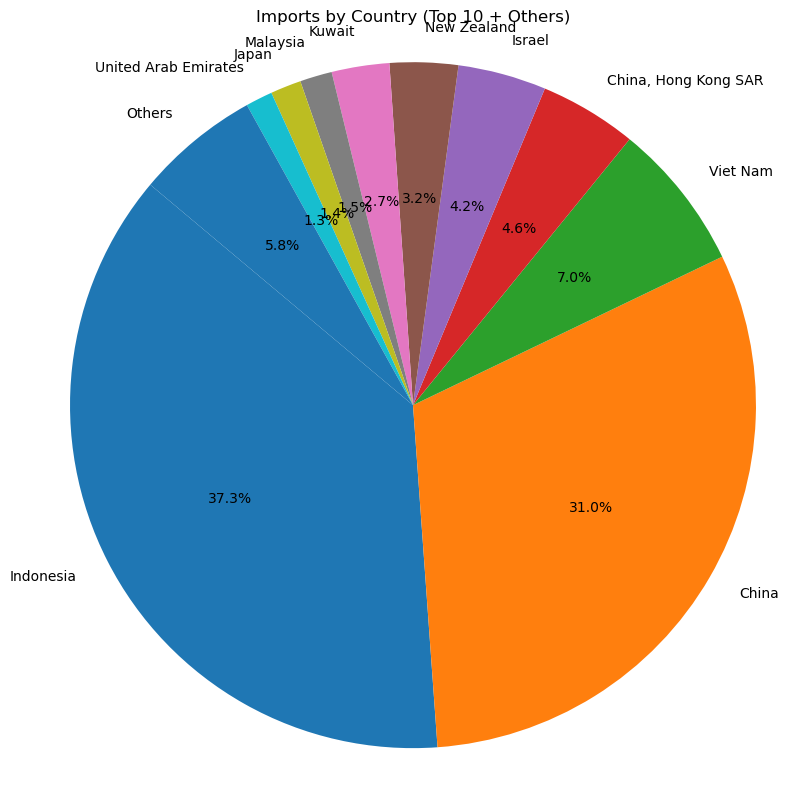

In [77]:
# Remove 'World' if present
if 'World' in imports_by_partner.index:
    imports_by_partner = imports_by_partner.drop('World')

if 'Areas, nes' in imports_by_partner.index:
    imports_by_partner = imports_by_partner.drop('Areas, nes')

# Sort descending
sorted_series = imports_by_partner.sort_values(ascending=False)

# Step 2: Top 10 countries
top_10 = sorted_series[:10]

# Step 3: Sum the rest as "Others"
others = sorted_series[10:].sum()

# Step 4: Append "Others" to the top 10
top_10_with_others = pd.concat([top_10, pd.Series({'Others': others})])

# Step 5: Plot
plt.figure(figsize=(8, 8))
plt.pie(top_10_with_others, labels=top_10_with_others.index, autopct='%1.1f%%', startangle=140)
plt.title('Imports by Country (Top 10 + Others)')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.show()
